# Label Detection

## Axes Detection
This code gives a best estimate of the x and y axis (horizontal and vertical axes) for the plot/chart.

In [1]:
import cv2, imutils, re, xlsxwriter
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
from pathlib import Path
from matplotlib import rcParams
from pytesseract import Output

In [2]:
# Directory of images to run the code on
img_dir = 'test2'
data_dir = 'data'
# Directory to save the output images
save_dir = 'out'

### Method to separate horizontal and vertical lines.

In [3]:
def segmentLines(lines, threshold = 10):
    hlines, vlines = [], []
    
    for line in lines:
        for (point1x, point1y, point2x, point2y) in line:
            # If x-values are near (i.e., within a threshold),
            # then the lines are vertical. Similarly, if y-values
            # are near, then the lines are horizontal. 
            
            if abs(point2x - point1x) < threshold:
                vlines.append(line)
            elif abs(point2y - point1y) < threshold:
                hlines.append(line)
    
    return hlines, vlines

### Function to detect x-axis and y-axis for a plot

In [4]:
def detectAxes(filepath):
    if filepath is None:
        return None, None
    
    image = cv2.imread(filepath)
    height, width, channels = image.shape
        
    # Convert the image to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    gray = cv2.adaptiveThreshold(gray,
                                 maxValue = 250,
                                 adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 thresholdType = cv2.THRESH_BINARY,
                                 blockSize = 11,
                                 C = 10)
            
    # Canny edge detection
    edges = cv2.Canny(gray, 0, 250, apertureSize = 3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180,
                            threshold = 200,
                            maxLineGap = 20,
                            minLineLength = min(height, width) // 2)
    
    # No lines detected
    if lines is None:
        return None, None
        
    # Segment the lines into horizontal and vertical
    h_lines, v_lines = segmentLines(lines, 10)

    # There are either no horizontal or vertical lines, return None
    # May be pie charts or not a plot, check further later.
    if len(h_lines) == 0 or len(v_lines) == 0:
        return None, None
        
    try:         
        y1_vals = [l[0][1] for l in h_lines]
        idx_max_y1 = y1_vals.index(max(y1_vals))
        xaxis = h_lines[idx_max_y1]
            
        x1_vals = [l[0][0] for l in v_lines]
        idx_min_x1 = x1_vals.index(min(x1_vals))
        yaxis = v_lines[idx_min_x1]
        
        return xaxis, yaxis
        
    except IndexError:
        return None, None

### Here we try to get text from the image using pytesseract

In [5]:
def getTextFromImage(filepath, xaxis, yaxis, grayscale=False):
    image_text = []
    
    image = cv2.imread(filepath)
    
    if not grayscale:
        height, width, _ = image.shape
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        height, width = gray.shape
        thresh,img_bin = cv2.threshold(image,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
        sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        sharpen = cv2.filter2D(gray, -1, sharpen_kernel)
        thresh = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
        image = 255 - img_bin
        
    d = pytesseract.image_to_data(image, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
    n_boxes = len(d['text'])

    # Pick only the positive confidence boxes
    for i in range(n_boxes):
            
        if int(d['conf'][i]) >= 0:
                
            text = d['text'][i].strip()
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image_text.append((d['text'][i], (x, y, w, h)))
            
    # Remove all the duplicates in (text, box) pairs
    return list(set(image_text))

### This function is to calculate the probable x-labels, y-labels and legend text

Here is the logic for the same

1. X-labels

    a. Check only the text boxes which are below the x-axis(, and to the right of y-axis).
    
    b. Run a line sweep from x-axis to the bottom of the image, and check when the sweeping line intersects with the maximum            number of text boxes.
    
    c. This maximum intersection gives all the x-labels



2. Y-labels:

    a. Check only the text boxes which are to the left of y-axis(, and to the top of x-axis).
    
    b. Run a line sweep from left end of the image to the y-axis position, and check when the sweeping line intersects with the        maximum number of text boxes.
    
    c. This maximum intersection gives all the y-labels


    
3. Legend text:
    
    a. Check only the text boxes in the remaining region (right to the y-axis and top of x-axis)
    
    b. Only Consider text boxes which have non-numeric text
    
    c. Run the sweeping line algorithm twice now - Once in the x-direction and the second time in the y-direction
    
    d. The maximum intersections gives all the legend texts.

In [6]:
def getProbableLabels(image, image_text, xaxis, yaxis):
    y_labels = []
    x_labels = []
    legends = []
    
    height, width, channels = image.shape
    
    for text, (textx, texty, w, h) in image_text:
        text = text.strip()
                    
        (x1, y1, x2, y2) = xaxis
        (x11, y11, x22, y22) = yaxis
            
        # To the left of y-axis and top of x-axis
        if (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == -1):
            y_labels.append((text, (textx, texty, w, h)))
            
        # To the right of y-axis and bottom of x-axis
        elif (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == 1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == 1):
            x_labels.append((text, (textx, texty, w, h)))
            
        # Top of x-axis and to the right of y-axis
        elif (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == 1):
            
            # Consider non-numeric only for legends
            if not bool(re.findall(r'\b[\d\.\d]+\b', text)):
                legends.append((text, (textx, texty, w, h)))
            
    # Get the y-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(x11):
        count = 0
        current = []
        for index, (text, rect) in enumerate(y_labels):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(y_labels[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
        
    y_labels = []
    for text, (textx, texty, w, h) in maxList:
        y_labels.append(text)
        #cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 0), 2)
        
    # Get the x-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(y1, height):
        count = 0
        current = []
        for index, (text, rect) in enumerate(x_labels):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(x_labels[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
    
    # Sort bounding rects by x coordinate
    def getYFromRect(item):
        return item[1]

    maxList.sort(key = getYFromRect)
    
    x_labels = []
    for text, (textx, texty, w, h) in maxList:
        x_labels.append(text)
        cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 0), 2)
    
    # Get possible legend text
    # For this, we need to search both top to
    # bottom and also from left to right.
    maxIntersection = 0
    maxList = []
    for i in range(y1):
        count = 0
        current = []
        for index, (text, rect) in enumerate(legends):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(legends[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
            
    for i in range(x11, width):
        count = 0
        current = []
        for index, (text, rect) in enumerate(legends):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(legends[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
        
    legends = []
    #legendBoxes = []
    for text, (textx, texty, w, h) in maxList:
        legends.append(text)
    #    legendBoxes.append((textx, texty, w, h))
        cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)
    
    #legendBoxes = mergeRects(legendBoxes)
    
    #for (textx, texty, w, h) in legendBoxes:
    #    cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)
    
    return image, x_labels, y_labels, legends

In [7]:
def lineIntersectsRectX(candx, rect):
    (x, y, w, h) = rect
    
    if x <= candx <= x + w:
        return True
    else:
        return False
    
def lineIntersectsRectY(candy, rect):
    (x, y, w, h) = rect
    
    if y <= candy <= y + h:
        return True
    else:
        return False

In [8]:
def getTextFromImageArray(image, mode):
    image_text = []
    
    if mode == 'y-text':
        image = cv2.transpose(image)
        image = cv2.flip(image, flipCode = 1)
        config = "-l eng --oem 1 --psm 6"
    elif mode == 'y-labels':
        config = "-l eng --oem 1 --psm 6 -c tessedit_char_whitelist=.0123456789"
    
    d = pytesseract.image_to_data(image, config = config, output_type = Output.DICT)
    
    n_boxes = len(d['text'])

    # Pick only the positive confidence boxes
    for i in range(n_boxes):
            
        if int(d['conf'][i]) >= 0:
                
            text = d['text'][i].strip()
            
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image_text.append((d['text'][i], (x, y, w, h)))
            
    # Remove all the duplicates in (text, box) pairs
    return list(set(image_text))

In [9]:
def maskImageForwardPass(filepath, start_idx):
    if path.name.endswith('.png') or path.name.endswith('.jpg') or path.name.endswith('.jpeg'):

        filepath = img_dir + "/" + path.name
        image = cv2.imread(filepath)
        height, width, channels = image.shape
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        start_idx = 1
        while start_idx <= width:
            if sum(gray[:, start_idx] < 200) != 0:
                break
            else:
                start_idx += 1
                
        end_idx = start_idx
        while end_idx <= width:
            if sum(gray[:, end_idx] < 200) == 0:
                break
            else:
                end_idx += 1
                
        gray[:, 1:start_idx] = 255
        gray[:, end_idx:width] = 255
        
        return gray, start_idx, end_idx

In [10]:
def maskImageBackwardPass(filepath, start_idx, end_idx):
    if path.name.endswith('.png') or path.name.endswith('.jpg') or path.name.endswith('.jpeg'):

        filepath = img_dir + "/" + path.name
        image = cv2.imread(filepath)
        height, width, channels = image.shape

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        while end_idx > start_idx:
            if sum(gray[:, end_idx] < 200) == 0:
                break
            else:
                end_idx -= 1
        
        gray[:, 1:start_idx] = 255
        gray[:, end_idx:width] = 255
        
        return gray

## Getting the Ratio for y-value matching 

In [11]:
def getRatio(image, image_text, xaxis, yaxis):
    list_text = []
    list_ticks = []
    
    height, width, channels = image.shape
    
    for text, (textx, texty, w, h) in image_text:
        text = text.strip()
                    
        (x1, y1, x2, y2) = xaxis
        (x11, y11, x22, y22) = yaxis
            
        # To the left of y-axis and top of x-axis
        if (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == -1):
            
        
            # Consider numeric only for ticks on y-axis
            if bool(re.findall(r'\b[\d\.\d]+\b', text)):
                list_text.append((text, (textx, texty, w, h)))
                
            
    # Get the y-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(x11):
        count = 0
        current = []
        for index, (text, rect) in enumerate(list_text):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(list_text[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
        
    list_text = []
    for text, (textx, texty, w, h) in maxList:
        list_text.append(float(text))
        list_ticks.append(float(texty+h))
        cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 0), 2)
        
    text_sorted = (sorted(list_text))
    ticks_sorted  = (sorted(list_ticks))
    
    ticks_diff = ([ticks_sorted[i] - ticks_sorted[i-1] for i in range(1, len(ticks_sorted))])
    text_diff = ([text_sorted[i] - text_sorted[i-1] for i in range(1, len(text_sorted))])
    ticks_diff1 = reject_outliers(np.array(ticks_diff), m=1)
    text_diff1 = reject_outliers(np.array(text_diff), m=1)
    
    normalize_ratio = np.array(text_diff).mean()/np.array(ticks_diff).mean()

   
    
    return image, text_sorted, normalize_ratio

In [12]:
def lineIntersectsRectX(candx, rect):
    (x, y, w, h) = rect
    
    if x <= candx <= x + w:
        return True
    else:
        return False
    
def lineIntersectsRectY(candy, rect):
    (x, y, w, h) = rect
    
    if y <= candy <= y + h:
        return True
    else:
        return False

In [13]:
def reject_outliers(data, m=1):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

## Writing to Excel workbook

In [14]:
def addToExcel(dataname, data, row):
    col = 0

    worksheet.write(row, col, dataname)
#     print(data)
    for content in data:
        col += 1
        worksheet.write(row, col, content)

## Matching the ratio for final data extraction 

In [15]:
def mergeRects(contours):
    rects = []
    rectsUsed = []

    # Just initialize bounding rects and set all bools to false
    for cnt in contours:
        rects.append(cv2.boundingRect(cnt))
        rectsUsed.append(False)

    # Sort bounding rects by x coordinate
    def getXFromRect(item):
        return item[0]

    rects.sort(key = getXFromRect)

    # Array of accepted rects
    acceptedRects = []

    # Merge threshold for x coordinate distance
    xThr = 5
    yThr = 5

    # Iterate all initial bounding rects
    for supIdx, supVal in enumerate(rects):
        if (rectsUsed[supIdx] == False):

            # Initialize current rect
            currxMin = supVal[0]
            currxMax = supVal[0] + supVal[2]
            curryMin = supVal[1]
            curryMax = supVal[1] + supVal[3]

            # This bounding rect is used
            rectsUsed[supIdx] = True

            # Iterate all initial bounding rects
            # starting from the next
            for subIdx, subVal in enumerate(rects[(supIdx+1):], start = (supIdx+1)):

                # Initialize merge candidate
                candxMin = subVal[0]
                candxMax = subVal[0] + subVal[2]
                candyMin = subVal[1]
                candyMax = subVal[1] + subVal[3]

                # Check if x distance between current rect
                # and merge candidate is small enough
                if (candxMin <= currxMax + xThr):

                    if not nearbyRectangle((candxMin, candyMin, candxMax - candxMin, candyMax - candyMin),
                                           (currxMin, curryMin, currxMax - currxMin, curryMax - curryMin), yThr):
                        break

                    # Reset coordinates of current rect
                    currxMax = candxMax
                    curryMin = min(curryMin, candyMin)
                    curryMax = max(curryMax, candyMax)

                    # Merge candidate (bounding rect) is used
                    rectsUsed[subIdx] = True
                else:
                    break

            # No more merge candidates possible, accept current rect
            acceptedRects.append([currxMin, curryMin, currxMax - currxMin, curryMax - curryMin])

    #for rect in acceptedRects:
    #    img = cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (121, 11, 189), 2)
    
    return acceptedRects

In [16]:
def nearbyRectangle(current, candidate, threshold):
    (currx, curry, currw, currh) = current
    (candx, candy, candw, candh) = candidate
    
    currxmin = currx
    currymin = curry
    currxmax = currx + currw
    currymax = curry + currh
    
    candxmin = candx
    candymin = candy
    candxmax = candx + candw
    candymax = candy + candh
    
    # If candidate is on top, and is close
    if candymax <= currymin and candymax + threshold >= currymin:
        return True
    
    # If candidate is on bottom and is close
    if candymin >= currymax and currymax + threshold >= candymin:
        return True
    
    # If intersecting at the top, merge it
    if candymax >= currymin and candymin <= currymin:
        return True
    
    # If intersecting at the bottom, merge it
    if currymax >= candymin and currymin <= candymin:
        return True
    
    # If intersecting on the sides or is inside, merge it
    if (candymin >= currymin and
        candymin <= currymax and
        candymax >= currymin and
        candymax <= currymax):
        return True
    
    return False

In [17]:
def euclidean(v1, v2):
    return sum((p - q) ** 2 for p, q in zip(v1, v2)) ** .5

def angle_between(p1, p2):
    
    deltaX = p1[0] - p2[0]
    deltaY = p1[1] - p2[1]

    #print(deltaX)
    #print(deltaY)
    return math.atan2(deltaY, deltaX) / math.pi * 180
    
def RectDist(rectA, rectB):
    (rectAx, rectAy, rectAw, rectAh) = rectA
    (rectBx, rectBy, rectBw, rectBh) = rectB
    
    angle = angle_between((rectAx + rectAw / 2, rectAy + rectAh / 2), (rectBx + rectBw / 2, rectBy + rectBh / 2))
    
    if (angle >= -5 and angle <= 5) or (angle <= -175 and angle >= -185) or (angle >= 175 and angle <= 185):
        if (rectBx > rectAx + rectAw):
            #print(rectA)
            #print(rectB)
            #print(angle)
            return euclidean([rectAx + rectAw / 2, rectAy + rectAh / 2], [rectBx + rectBw / 2, rectBy + rectBh / 2])
        else:
            return sys.maxsize
    else:
        return sys.maxsize

## Saving y-values in our data excel sheet 

In [18]:
import ast, cv2, re, sys
import math
import json


images = []
texts = []

def getYVal(img_dir):
    yValueDict = {}
    for path in Path(img_dir).iterdir():
        if path.name.endswith('.png') or path.name.endswith('.jpg'):
            filepath = img_dir + "/" + path.name
            img = cv2.imread(filepath)
            xaxis, yaxis = detectAxes(filepath)

            if xaxis is None or yaxis is None:
                continue

            for line in [xaxis]:
                for (x1, y1, x2, y2) in line:
                    cv2.line(img, (x1, y1), (x2, y2),  (0, 0, 255), 2)
                    xaxis = (x1, y1, x2, y2)

            for line in [yaxis]:
                for (x1, y1, x2, y2) in line:
                    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    yaxis = (x1, y1, x2, y2)

            image_text = getTextFromImage(filepath, xaxis, yaxis)
            img, x_labels, _, legends = getProbableLabels(img, image_text, xaxis, yaxis)
            try:
                img, list_text, normalize_ratio = getRatio(img, image_text, xaxis, yaxis)



                rcParams['figure.figsize'] = 15, 8





                d = pytesseract.image_to_data(img, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
                n_boxes = len(d['text'])

                # Color detection
                h, w, _ = np.shape(img)

                image = img.reshape((h * w, 3))

                # Remove white and near-by pixels
                threshold = 5
                for r in range(255 - threshold, 256):
                    for g in range(255 - threshold, 256):
                        for b in range(255 - threshold, 256):
                            image = image[np.where((image != [r, g, b]).any(axis = 1))]

                values, counts = np.unique(image, axis = 0, return_counts = True)

                greater_counts = np.where(counts >= 100)
                values, counts = values[greater_counts], counts[greater_counts]

                sort_indices = np.argsort(-counts)
                values, counts = values[sort_indices], counts[sort_indices]

                #print(len(values))

                groups = []
                groupcounts = []


                for idx, value in enumerate(values):
                    grouped = False

                    for groupid, group in enumerate(groups):
                        for member in group:
                            r, g, b = member
                            vr, vg, vb = value


                            if (abs(vr.astype(np.int16) - r.astype(np.int16)) <= 5 and
                                abs(vg.astype(np.int16) - g.astype(np.int16)) <= 5 and
                                abs(vb.astype(np.int16) - b.astype(np.int16)) <= 5):
                                group.append(value)
                                groupcounts[groupid] += counts[idx]
                                grouped = True

                                break

                        if grouped:
                            break

                    if not grouped:

                        groups.append([value])
                        groupcounts.append(counts[idx])


                groupcounts = np.array(groupcounts)
                sort_indices = np.argsort(-groupcounts)
                new_groups = [groups[i] for i in sort_indices]
                groups = new_groups
        #         print(len(groups))


                for i in range(len(groups[:4])):

                    img = cv2.imread(img_dir + "/" + path.name)
                    # Plot the distribution
                    rcParams['figure.figsize'] = 40, 4
                    rcParams['figure.max_open_warning'] = 0

                    mask = None
                    for value in groups[i]:
                        COLOR_MIN = np.array([value[0], value[1], value[2]], np.uint8)
                        COLOR_MAX = np.array([value[0], value[1], value[2]], np.uint8)

                        if mask is None:
                            mask = cv2.inRange(img, COLOR_MIN, COLOR_MAX)
                        else:
                            mask = mask | cv2.inRange(img, COLOR_MIN, COLOR_MAX)

                    image = cv2.bitwise_and(img, img, mask = mask)
                    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, (3, 3))


                    edged = cv2.Canny(image, 0, 250)
                    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    contours = [contour for contour in contours if cv2.contourArea(contour) > 0.]

                    # Remove noisy ones!
                    if len(contours) == 0 or len(contours) > 100:
                        continue

                    contours = [cv2.approxPolyDP(contour, 3, True) for contour in contours]

                    rects = mergeRects(contours)
                    textBoxes = []
                    legends = []

                    for rectBox in rects:
                        min_distance = sys.maxsize
                        closestBox = None
                        legendtext = None

                        for text, textBox in image_text:    
                            if RectDist(rectBox, textBox) < min_distance:
                                closestBox = textBox
                                min_distance = RectDist(rectBox, textBox)
                                legendtext = text
                                    #print(text)

                        if closestBox is not None:
                            textBoxes.append(closestBox)

                        if legendtext is not None:
                            legends.append(legendtext)

                    fig = plt.figure()

                    rcParams['figure.figsize'] = 15, 8
                    list_len = []



                    for rect in rects:
                        img = cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (121, 11, 189), 2)
                        list_len.append(float(rect[3]))

                    # y-values will be a product of the normalize ratio and each length              
                    y_val = [round(l*normalize_ratio,1) for l in list_len]

                   # Print the output here!


                    if path.name in yValueDict:
                        yValueDict[path.name].append([legends[-1]])
                        yValueDict[path.name].append(y_val)
                    else:

                        yValueDict[path.name] = [legends[-1]]
                        yValueDict[path.name].append(y_val)


                    for box in textBoxes:
                        (x, y, w, h) = box
                        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)




                    ax = fig.add_subplot(133)
                    ax.imshow(img, aspect = 'auto')
            except Exception:
                pass 
    return yValueDict


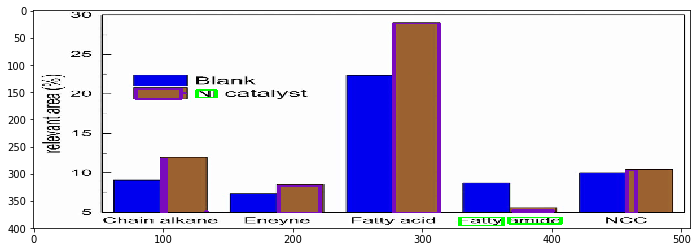

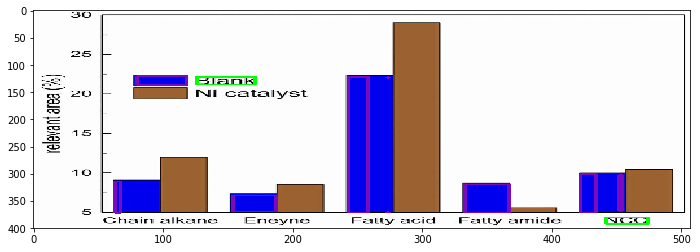

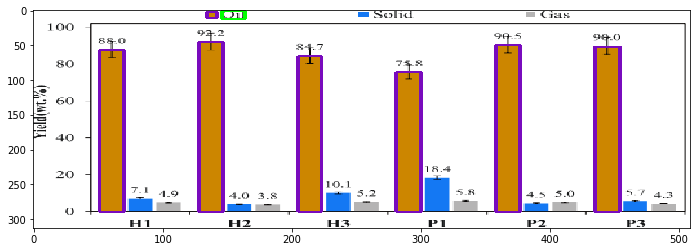

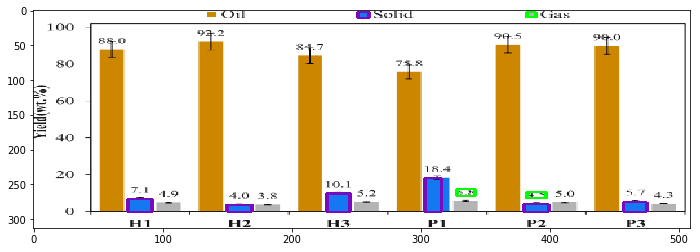

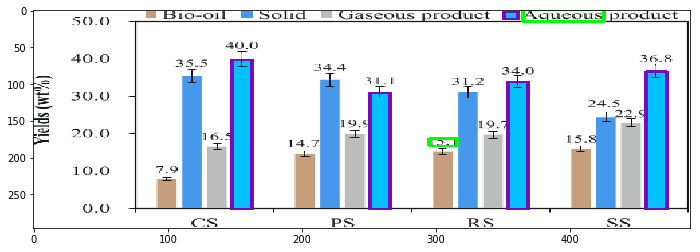

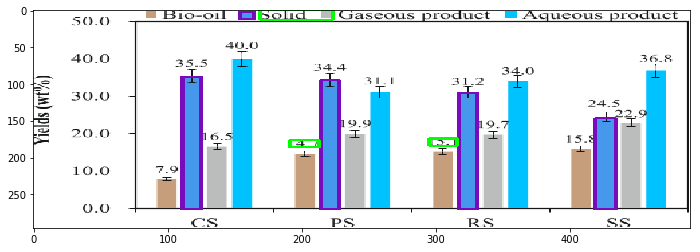

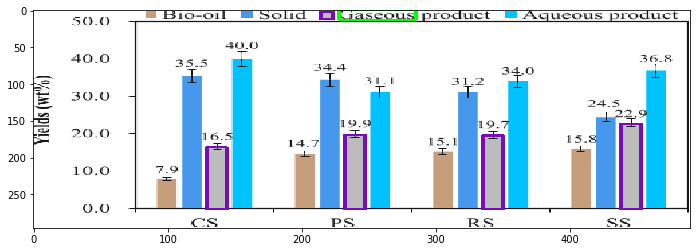

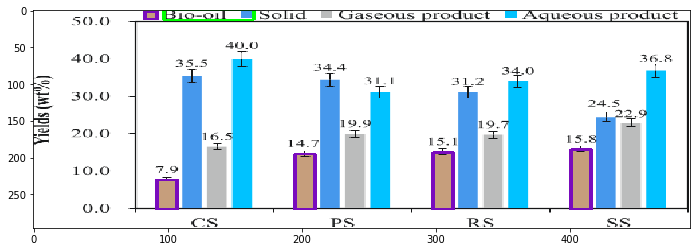

In [19]:
yValueDict = getYVal(img_dir)

In [20]:
yValueDict

{'1-s2.0-S0960852417320539-main-Figure2-1.png': ['amide',
  [1.3, 0.3, 6.8, 0.1, 0.1, 3.4, 23.9, 0.2, 5.3],
  ['NCC'],
  [4.0, 1.1, 2.0, 17.2, 0.1, 0.1, 3.5, 4.8, 4.6]],
 '1-s2.0-S004896971831547X-main-Figure2-1.png': ['Oil',
  [88.0, 92.1, 3.0, 84.5, 75.8, 90.6, 89.9],
  ['4s'],
  [6.8, 3.8, 9.9, 3.0, 18.2, 4.2, 5.3]],
 '1-s2.0-S0016236119323397-main-Figure1-1.png': ['Aqueous',
  [40.0, 31.1, 2.0, 34.1, 36.8],
  ['15.1'],
  [35.4, 2.0, 34.4, 31.1, 24.4],
  ['Gaseous'],
  [16.5, 2.0, 19.9, 19.7, 22.8],
  ['Bio-o1l_B'],
  [2.0, 7.9, 14.8, 15.2, 15.9]]}

In [21]:
import json

with open('urldata.json') as handler:
    urldata = json.load(handler)

0 amide
1 [1.3, 0.3, 6.8, 0.1, 0.1, 3.4, 23.9, 0.2, 5.3]
2 ['NCC']
3 [4.0, 1.1, 2.0, 17.2, 0.1, 0.1, 3.5, 4.8, 4.6]
file name    :   1-s2.0-S0960852417320539-main-Figure2-1.png
x-labels     :   ['Chain', 'alkane', 'Eneyne', 'Fatty', 'acid', 'Fatty', 'amide', 'NCC']
y-text       :   ['relevant', 'area', '(%)']
y-labels     :   ['30', '25', '20', '15', '10', '5']
legends      :   ['catalyst', 'Ni', 'HE']
Y- Values    :   amide [1.3, 0.3, 6.8, 0.1, 0.1, 3.4, 23.9, 0.2, 5.3] ['NCC'] [4.0, 1.1, 2.0, 17.2, 0.1, 0.1, 3.5, 4.8, 4.6]

0 Oil
1 [88.0, 92.1, 3.0, 84.5, 75.8, 90.6, 89.9]
2 ['4s']
3 [6.8, 3.8, 9.9, 3.0, 18.2, 4.2, 5.3]
file name    :   1-s2.0-S004896971831547X-main-Figure2-1.png
x-labels     :   ['HL', 'Hw', 'HB', 'PL', 'p2', 'P3']
y-text       :   ['‘Neld(wt.7)', '—']
y-labels     :   ['00', '80', '60', '40', '20', '0']
legends      :   ['m=', '=e', 'Gas', 'Solid', 'Oil']
Y- Values    :   Oil [88.0, 92.1, 3.0, 84.5, 75.8, 90.6, 89.9] ['4s'] [6.8, 3.8, 9.9, 3.0, 18.2, 4.2, 5.3]

0 A

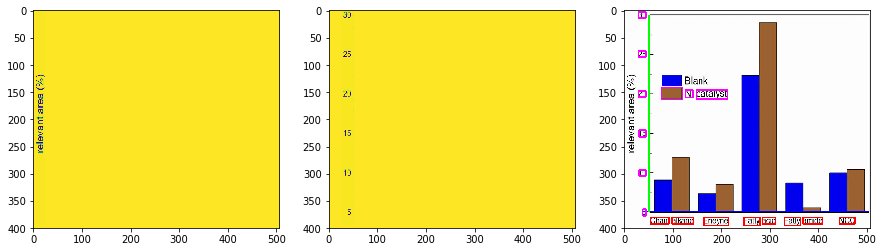

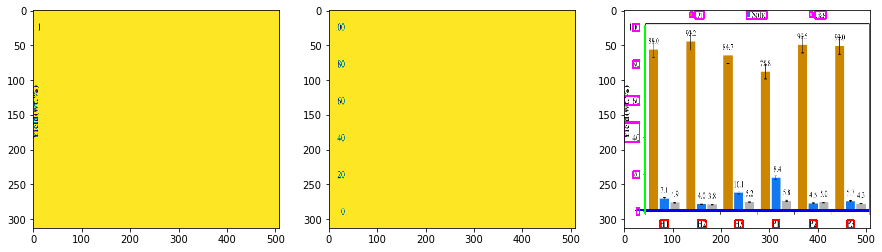

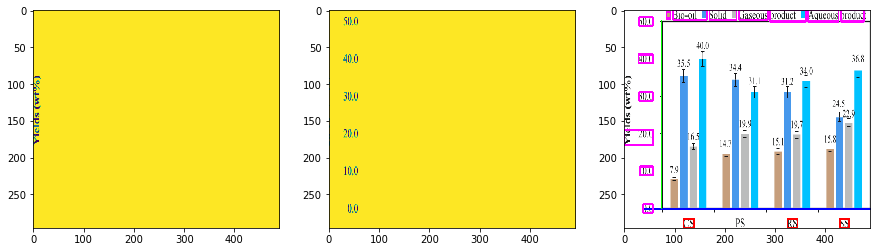

In [23]:
workbook = xlsxwriter.Workbook('FigureData1.xlsx')

for path in Path(img_dir).iterdir():
#     print(path.name)
    if path.name.endswith('.png') or path.name.endswith('.jpg') or path.name.endswith('.jpeg'):
        if path.name in yValueDict:

            filepath = img_dir + "/" + path.name
            image = cv2.imread(filepath)
            height, width, channels = image.shape
            xaxis, yaxis = detectAxes(filepath)
            y_text, y_labels = [], []

            if xaxis is None or yaxis is None:
                continue

            for line in [xaxis]:
                for (x1, y1, x2, y2) in line:
                    xaxis = (x1, y1, x2, y2)

            for line in [yaxis]:
                for (x1, y1, x2, y2) in line:
                    yaxis = (x1, y1, x2, y2)

            rcParams['figure.figsize'] = 15, 4
            fig, ax = plt.subplots(1, 3)

            gray, start_idx, end_idx = maskImageForwardPass(filepath, 1)
            y_text_list = getTextFromImageArray(gray, 'y-text')

            # Sort bounding rects by x coordinate
            def getXFromRect(item):
                return item[1][0]

            y_text_list.sort(key = getXFromRect)        
            for text, (textx, texty, w, h) in y_text_list:
                y_text.append(text)

            ax[0].imshow(gray, aspect = 'auto')

            gray = maskImageBackwardPass(filepath, end_idx, yaxis[0])
            y_labels_list = getTextFromImageArray(gray, 'y-labels')

            # Sort bounding rects by y coordinate
            def getYFromRect(item):
                return item[1][1]

            y_labels_list.sort(key = getYFromRect)
            for text, (textx, texty, w, h) in y_labels_list:
                y_labels.append(text)

            image_text = getTextFromImage(filepath, xaxis, yaxis, grayscale=False)
            image, x_labels, _, legends = getProbableLabels(image, image_text, xaxis, yaxis)





            # Write to Excel
            worksheet = workbook.add_worksheet()
            
            
            addToExcel("caption", [urldata[path.name]], 0)
            addToExcel("file name", path.name[::-4]+".pdf",1)
            addToExcel("x-labels", x_labels, 2)
            addToExcel("y-text", y_text, 3)
            addToExcel("y-labels", y_labels, 4)
            addToExcel("legends", legends, 5)
            
            for col_num, data in enumerate(yValueDict[path.name]):
                print(col_num, data)
                if type(data) != list:
                    worksheet.write(9+col_num, 0, "Y-values:" + "\n\n" + str(data))
                else:
                    for pos,d in enumerate(data):
                        worksheet.write(9+col_num, pos, str(d))



            # Print the output here!
            print("file name    :  ", path.name)
            print("x-labels     :  ", x_labels)
            print("y-text       :  ", y_text)
            print("y-labels     :  ", y_labels)
            print("legends      :  ", legends)
            print("Y- Values    :  ", ' '.join([str(elem) for elem in yValueDict[path.name]]), end = "\n\n")

            for (x1, y1, x2, y2) in [xaxis]:
                cv2.line(image, (x1, y1), (x2, y2),  (0, 0, 255), 2)

            for (x1, y1, x2, y2) in [yaxis]:
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            for text, (textx, texty, w, h) in y_labels_list:
                cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)

            ax[1].imshow(gray, aspect = 'auto')
            ax[2].imshow(image, aspect = 'auto')

            # Insert the image
    #         plt.savefig(path.name)
            worksheet.insert_image('J21', filepath)

# Close the excel workbook!
workbook.close()